In [495]:
import pandas as pd
import numpy as np
import heejin
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler,LabelEncoder,RobustScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_squared_log_error,classification_report,roc_curve

In [496]:
dataDF = pd.read_csv('../data/Hamburger.csv', encoding= 'latin1')

In [497]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  1068 non-null   object 
 1   item        1068 non-null   object 
 2   calories    1068 non-null   float64
 3   sodium      1068 non-null   float64
 4   sugar       1068 non-null   float64
 5   total_fat   1068 non-null   float64
 6   protein     974 non-null    float64
dtypes: float64(5), object(2)
memory usage: 58.5+ KB


In [498]:
# 인코딩
dataDF['restaurant'].nunique()  # 총 13개의 브랜드

13

In [499]:
dataDF['restaurant'].unique() # Mcdonalas와 macdonald / Burger King과 burgerking => 이름 통일

array(['Mcdonalds', 'Chick Fil-A', 'Sonic', 'Arbys', 'Burger King',
       'Dairy Queen', 'Subway', 'Taco Bell', 'burgerking', 'lotteria',
       'macdonald', 'no_brand_burger', 'prank_burger'], dtype=object)

In [500]:
dataDF['restaurant'].replace('macdonald','McDonalds',inplace=True)
dataDF['restaurant'].replace('Mcdonald','McDonalds',inplace=True)
dataDF['restaurant'].replace('Mcdonalds','McDonalds',inplace=True)
dataDF['restaurant'].replace('burgerking','Burger King',inplace = True)

In [501]:
dataDF['restaurant'].unique()

array(['McDonalds', 'Chick Fil-A', 'Sonic', 'Arbys', 'Burger King',
       'Dairy Queen', 'Subway', 'Taco Bell', 'lotteria',
       'no_brand_burger', 'prank_burger'], dtype=object)

In [502]:
# 중복값 제거 - 2개 
dataDF.duplicated().sum()
dataDF.drop_duplicates(inplace=True)

In [503]:
# 결측치 제거 - protein - 94개
dataDF.isna().sum()
dataDF.dropna(subset = 'protein',inplace = True)
# 결측치 제거 확인
dataDF.isna().sum()

restaurant    0
item          0
calories      0
sodium        0
sugar         0
total_fat     0
protein       0
dtype: int64

In [504]:
# 이상치 제거할 필요 X
heejin.find_outlier_iqr(dataDF)

iqr - calories의 이상치 개수 : 30
iqr - sodium의 이상치 개수 : 25
iqr - sugar의 이상치 개수 : 139
iqr - total_fat의 이상치 개수 : 32
iqr - protein의 이상치 개수 : 43


In [505]:
# 순서가 없는 범주형 데이터 -> 원핫인코딩 실시
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(dataDF[['restaurant']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['restaurant']))
encodingDF = pd.concat([dataDF,encoded_df],axis=1)

In [506]:
encodingDF.corr(numeric_only=True)['calories'].abs().sort_values(ascending=False) # 맥도날드인가 아닌가는 상관계수 넣어볼 만 하다.

calories                      1.000000
sodium                        0.814501
total_fat                     0.763824
sugar                         0.211366
protein                       0.171311
restaurant_Sonic              0.124198
restaurant_no_brand_burger    0.115918
restaurant_Burger King        0.078933
restaurant_lotteria           0.069776
restaurant_McDonalds          0.050599
restaurant_Arbys              0.049537
restaurant_Chick Fil-A        0.045511
restaurant_Subway             0.035740
restaurant_Taco Bell          0.035692
restaurant_Dairy Queen        0.034518
restaurant_prank_burger       0.008871
Name: calories, dtype: float64

In [507]:
dataDF.corr(numeric_only=True)['calories'].sort_values(ascending=False) 

calories     1.000000
sodium       0.814501
total_fat    0.763824
sugar        0.211366
protein      0.171311
Name: calories, dtype: float64

In [508]:
# 타겟 : calories
# 피쳐 : sodium, sugar, total_fat, portein
targetSR = dataDF['calories']
featureDF = dataDF[dataDF.columns[3:]]
targetSR.shape , featureDF.shape

((972,), (972, 4))

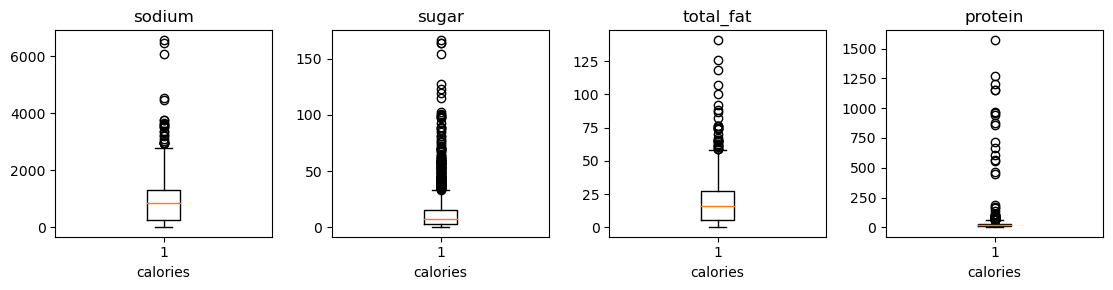

In [509]:
plt.figure(figsize = (14,3))
heejin.print_box(1,5,targetSR,featureDF)

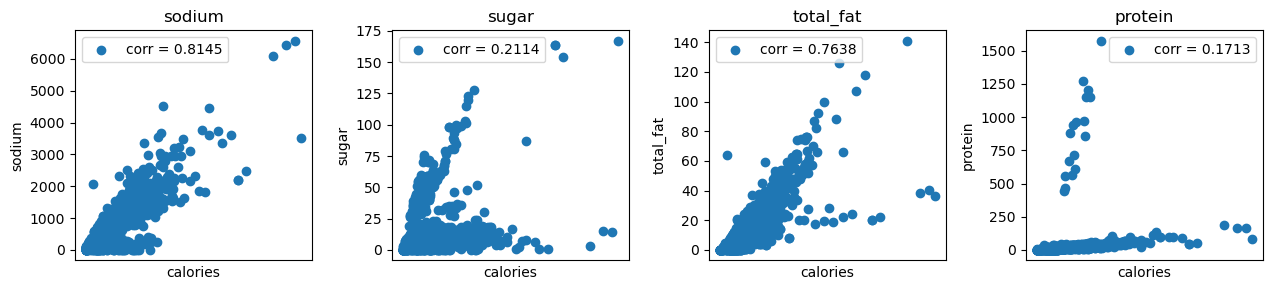

In [510]:
plt.figure(figsize = (16,3))
heejin.print_scatter(1,5,targetSR,featureDF) # 약간 선형이 있나...? -> data 다시 확인

In [511]:
# 피쳐들끼리 상호관계 있는지 확인
featureDF.corr() # total_fat과 sodium 상관관계 높음

,sodium,sugar,total_fat,protein
sodium,1.000000,-0.175234,0.707923,-0.010113
sugar,-0.175234,1.000000,-0.088508,0.064603
total_fat,0.707923,-0.088508,1.000000,0.080772
protein,-0.010113,0.064603,0.080772,1.000000


In [512]:
#  total_fat과 sodium poly 진행 
selected_features = ['total_fat', 'sodium']

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(featureDF[selected_features])

poly_featureDF = pd.DataFrame(poly_features, columns=[f'total_fat & sodium {i}' for i in range(1,10)])

# 다항 특성을 포함한 데이터프레임과 원래의 데이터프레임을 합치기
poly_featureDF = pd.concat([dataDF, poly_featureDF], axis=1)
poly_featureDF.dropna(inplace=True)
poly_targetSR = poly_featureDF['calories']
poly_featureDF = poly_featureDF[poly_featureDF.columns[3:]]
poly_featureDF.shape, poly_targetSR.shape

((897, 13), (897,))

In [513]:
r_max = heejin.find_random_state(featureDF,targetSR)

radom_state = 29
score : 0.9160878170953889


In [514]:
# 학습용 데이터셋, 검증용 데이터셋 분리
xtrain,xtest,ytrain,ytest = train_test_split(featureDF,targetSR,test_size=0.2, random_state=r_max)

In [515]:
# 스케일링 진행
heejin.find_scaler(xtrain,ytrain,xtest,ytest, RandomForestRegressor()) # mae와 rmse가 제일 낮은 StandardScaler() 선택

model : RandomForestRegressor()
scaler : StandardScaler()
Train score : 0.9766922063417162
Test score : 0.9411490545613236

[모델 설명도]
R2 : 0.9411490545613236
[에러]
MAE : 55.767472649572646
MSE : 7724.632066936688
RMSE : 87.8898860332444

--------------------------------------
model : RandomForestRegressor()
scaler : MinMaxScaler()
Train score : 0.9817602152594551
Test score : 0.9406229096216217

[모델 설명도]
R2 : 0.9406229096216217
[에러]
MAE : 57.263095897435896
MSE : 7793.692572979242
RMSE : 88.2818926676317

--------------------------------------
model : RandomForestRegressor()
scaler : RobustScaler()
Train score : 0.9789504228028431
Test score : 0.9472186628279263

[모델 설명도]
R2 : 0.9472186628279263
[에러]
MAE : 54.87070068376068
MSE : 6927.950037438979
RMSE : 83.23430805526637

--------------------------------------


In [516]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [517]:
# for i in range(1,100):
#     model = RandomForestRegressor(random_state=i)
#     model.fit(xtrain, ytrain)
#     if model.score(xtrain,ytrain)> 0.98:
#         print(i,model.score(xtrain,ytrain), model.score(xtest,ytest))

In [518]:
random_state_list = []
for i in range(1,50):
    model = RandomForestRegressor(random_state=i)
    model.fit(xtrain, ytrain)   
    random_state_list.append(model.score(xtest,ytest))
    max_score = max(random_state_list)
print(f'random_state = {random_state_list.index(max_score)+1}\nscore : {max_score}')

random_state = 18
score : 0.950145702659303


In [525]:
model = RandomForestRegressor(random_state=18)
model.fit(xtrain, ytrain)

RandomForestRegressor(random_state=18)

In [520]:
model.score(xtrain,ytrain),model.score(xtest, ytest) # 조금 과적합

(0.9799029022999607, 0.950145702659303)

Text(0.5, 1.0, '[feature importance]')

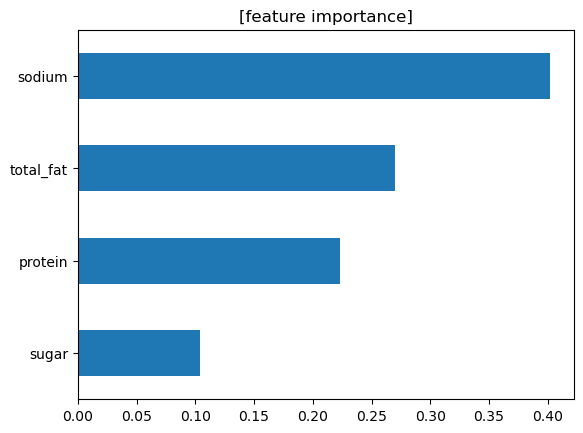

In [521]:
# feature importance 확인
import_feature = pd.Series(model.feature_importances_, index=featureDF.columns)
import_feature.sort_values(ascending=True, inplace=True)
import_feature.plot(kind='barh')
plt.title('[feature importance]')

max_depth : 과적합을 방지하기 위하여 의사결정나무의 depth 최대 값을 제한
min_samples_split : split을 끝낼 node의 sample 최소 갯수 선정, 클수록 과적합이 방지되지만, 너무 크면 split이 제대로 되지 않을 수 있음

In [524]:
# 랜덤 포레스트 모델 파라미터 조절
params = { 'n_estimators' : [10,50,100,200,400], # 결정 트리의 개수
           'max_depth' : [5,10,15,20], # 트리의 최대 깊이 (과적합 제어)
           'min_samples_split' : [5,10,15,20], # 노드를 분할하기 위한 최소한의 샘플 데이터 수
           'max_features' : ['sqrt', 'log2', None] # 최적의 분할을 위해 고려할 피쳐의 최대 개수
            }
cv = GridSearchCV(model, param_grid=params,cv = 5,return_train_score=True, n_jobs=-1)
cv.fit(xtrain,ytrain)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=18), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [5, 10, 15, 20],
                         'n_estimators': [10, 50, 100, 200, 400]},
             return_train_score=True)

In [526]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.036377,0.003844,0.003151,0.000435,5,sqrt,5,10,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.808761,...,0.814681,0.033409,239,0.895755,0.906491,0.905915,0.912659,0.919384,0.908041,0.007847
1,0.157786,0.002560,0.008586,0.000454,5,sqrt,5,50,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.853202,...,0.840176,0.039686,95,0.900408,0.915927,0.916458,0.915277,0.924306,0.914475,0.007762
2,0.338889,0.010089,0.017316,0.001566,5,sqrt,5,100,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.863043,...,0.840441,0.034024,89,0.904071,0.915696,0.917393,0.914691,0.923912,0.915152,0.006404
3,0.651377,0.023190,0.029219,0.000935,5,sqrt,5,200,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.848844,...,0.840951,0.035302,79,0.902304,0.916724,0.917454,0.914660,0.923893,0.915007,0.007062
4,1.282166,0.089984,0.058801,0.001725,5,sqrt,5,400,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.846501,...,0.839826,0.036653,103,0.901865,0.917424,0.918039,0.914154,0.924467,0.915190,0.007454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.055343,0.006590,0.003245,0.001019,20,None,20,10,"{'max_depth': 20, 'max_features': None, 'min_s...",0.782036,...,0.823839,0.046962,226,0.884606,0.904262,0.909402,0.915748,0.905112,0.903826,0.010435
236,0.302813,0.017105,0.013030,0.007359,20,None,20,50,"{'max_depth': 20, 'max_features': None, 'min_s...",0.799307,...,0.833320,0.046173,155,0.895287,0.905609,0.915561,0.907376,0.905850,0.905937,0.006453
237,0.640428,0.058019,0.017770,0.003241,20,None,20,100,"{'max_depth': 20, 'max_features': None, 'min_s...",0.794202,...,0.831241,0.045881,175,0.898319,0.907356,0.914365,0.910653,0.906207,0.907380,0.005348
238,1.302449,0.025432,0.044582,0.007304,20,None,20,200,"{'max_depth': 20, 'max_features': None, 'min_s...",0.788362,...,0.830196,0.048382,180,0.895572,0.910819,0.914601,0.913090,0.906884,0.908193,0.006825


In [527]:
best_model = cv.best_estimator_
cv.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=5,
                      n_estimators=50, random_state=18)

In [529]:
best_model.score(xtrain,ytrain),best_model.score(xtest,ytest) # 와 씨 과적합 해결;;

(0.9604551139369996, 0.9476294323874069)

In [ ]:
pd.DataFrame(cv.cv_results_)

In [528]:
ypre = best_model.predict(xtest)
r2 = r2_score(ytest, ypre)
mse = mean_squared_error(ytest, ypre)
mae = mean_absolute_error(ytest, ypre)
rmse = mean_squared_error(ytest, ypre, squared=False)
print(f'''
[모델 설명도]\nR2 : {r2}\n[에러]\nMAE : {mae}\nMSE : {mse}\nRMSE : {rmse}\n--------------------------------------
''')


[모델 설명도]
R2 : 0.9476294323874069
[에러]
MAE : 57.07360880221679
MSE : 6874.033423395934
RMSE : 82.9097908777723
--------------------------------------


In [ ]:
import joblib
import os

In [ ]:
# 모델 저장
model_dir = '../model/'
model_filename = model_dir + 'RandomForest.pkl'

# 저장 폴더 존재 여부 확인 후 저장
if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
joblib.dump(best_model,model_filename)

In [ ]:
## poly data로 다시 해보기
poly_xtrain,poly_xtest,ytrain,ytest = train_test_split(poly_featureDF,poly_targetSR, random_state=r_max, test_size=0.2)
poly_xtrain.shape, poly_xtest.shape, ytrain.shape

In [ ]:
scaler = StandardScaler()
poly_xtrain = scaler.fit_transform(poly_xtrain)
poly_xtest = scaler.transform(poly_xtest)

In [ ]:
model = RandomForestRegressor(random_state=18)
model.fit(poly_xtrain,ytrain)
model.score(poly_xtrain,ytrain),model.score(poly_xtest,ytest) # 과적합 더 심함

In [ ]:
# 랜덤 포레스트 모델 파라미터 조절

params = { 'n_estimators' : [10,50,100,200,400],
           'max_depth' : [5,10,15,20],
           'max_features' : [1,2,3,4],
           'min_samples_split' : [5,10,15,20],
            }

cv = GridSearchCV(model, param_grid=params,cv = 5,return_train_score=True)
cv.fit(poly_xtrain,ytrain)

In [ ]:
cv.score(poly_xtrain,ytrain),cv.score(poly_xtest,ytest) # poly한 모델이 성능이 더 안좋음. but 튜닝 후 과대적합 조금 완화